<a href="https://colab.research.google.com/github/prananto/baud.prananto/blob/main/Face_Recognition_using_Facenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download and extract files:

facenet_keras.h5

datakelas.zip

In [1]:
!gdown --id 1kv4Q5T0dNjWSVWcV6_IU9zXq4-5eszh9
!gdown --id 1jt1BltL_8PSDLtT00VwkO57YsR23IE9b
from zipfile import ZipFile
file_name = "/content/datakelas.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1kv4Q5T0dNjWSVWcV6_IU9zXq4-5eszh9
To: /content/facenet_keras.h5
100% 92.4M/92.4M [00:02<00:00, 44.1MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1jt1BltL_8PSDLtT00VwkO57YsR23IE9b
To: /content/datakelas.zip
100% 26.7M/26.7M [00:01<00:00, 13.9MB/s]
Done


Extract the faces from photographs in datakelas.zip

In [2]:
!pip install mtcnn

from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN

# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces

# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)

# load train dataset
trainX, trainy = load_dataset('/content/datakelas/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('/content/datakelas/val/')
# save arrays to one file in compressed format
savez_compressed('kelas-dataset.npz', trainX, trainy, testX, testy)

     |████████████████████████████████| 2.3 MB 4.1 MB/s 
>loaded 1 examples for class: m_khaerul_naim
>loaded 1 examples for class: arief_ichwani
>loaded 2 examples for class: dewi_tresnawati
>loaded 5 examples for class: handoko_supeno
>loaded 2 examples for class: ahmad_luky_ramdani
>loaded 1 examples for class: varuliantor_dear
>loaded 1 examples for class: leni_fitriani
>loaded 2 examples for class: imam_ekowicaksono
>loaded 1 examples for class: sulthoni_ashiddiiqi
>loaded 1 examples for class: ricky_isfandiari
>loaded 2 examples for class: mina_ismu_rahayu
>loaded 2 examples for class: baud_prananto
>loaded 1 examples for class: kemas_muhammad_irsan_riza
>loaded 4 examples for class: rahman_indra_kesuma
>loaded 1 examples for class: yulrio_brianorman
>loaded 1 examples for class: achmad_indra_aulia
>loaded 2 examples for class: hartanto_tantriawan
>loaded 2 examples for class: reza_budiawan
>loaded 2 examples for class: arief_sartono
>loaded 3 examples for class: lathifah_arief
>

Calculate Face Embedding

In [3]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model

# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

# load the face dataset
data = load('kelas-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the facenet model
model = load_model('facenet_keras.h5')
print('Loaded Model')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('kelas-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (43, 160, 160, 3) (43,) (2, 160, 160, 3) (2,)
Loaded Model
(43, 128)
(2, 128)


Develop Classifier

Predicted: ahmad_luky_ramdani (2.816)
Expected: ahmad_luky_ramdani


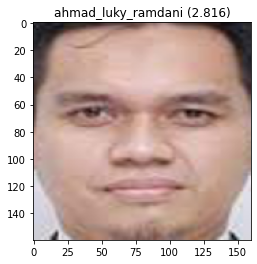

In [5]:
# develop a classifier for the Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
# load faces
data = load('kelas-dataset.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('kelas-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()